In [1]:
import os
import sys
import timeit
import random

import numpy as np

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
import glob
import os.path as op
import cPickle as pickle
from abc import ABCMeta, abstractmethod


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
#mostly from stanford Deep NLP course source

class Corpus(object):
    
    __metaclass__ = ABCMeta
    
    def __init__(self, corpusPath):
        self.corpusPath = corpusPath
    
    @abstractmethod
    def sentences(self):
        return None
    
    
    def tokens(self):
        if hasattr(self, "_tokens") and self._tokens:
            return self._tokens

        tokens = dict()
        tokenfreq = dict()
        wordcount = 0
        revtokens = []
        idx = 0

        for sentence in self.sentences():
            for w in sentence:
                wordcount += 1
                if not w in tokens:
                    tokens[w] = idx
                    revtokens += [w]
                    tokenfreq[w] = 1
                    idx += 1
                else:
                    tokenfreq[w] += 1

        tokens["UNK"] = idx
        revtokens += ["UNK"]
        tokenfreq["UNK"] = 1
        wordcount += 1

        self._tokens = tokens
        self._tokenfreq = tokenfreq
        self._wordcount = wordcount
        self._revtokens = revtokens
        return self._tokens
    
    def numSentences(self):
        if hasattr(self, "_numSentences") and self._numSentences:
            return self._numSentences
        else:
            self._numSentences = len(self.sentences())
            return self._numSentences
        
    def getRandomContext(self, C=5):
        allsent = self.allSentences()
        sentID = random.randint(0, len(allsent) - 1)
        sent = allsent[sentID]
        wordID = random.randint(0, len(sent) - 1)

        context = sent[max(0, wordID - C):wordID] 
        if wordID+1 < len(sent):
            context += sent[wordID+1:min(len(sent), wordID + C + 1)]

        centerword = sent[wordID]
        context = [w for w in context if w != centerword]

        if len(context) > 0:
            return centerword, context
        else:
            return self.getRandomContext(C) 
        

        
    def allSentences(self):
        if hasattr(self, "_allsentences") and self._allsentences:
            return self._allsentences

        sentences = self.sentences()
        rejectProb = self.rejectProb()
        tokens = self.tokens()
        allsentences = [[w for w in s 
            if 0 >= rejectProb[tokens[w]] or random.random() >= rejectProb[tokens[w]]]
            for s in sentences * 30]

        allsentences = [s for s in allsentences if len(s) > 1]
        
        self._allsentences = allsentences
        
        return self._allsentences  

    
    def rejectProb(self):
        if hasattr(self, '_rejectProb') and self._rejectProb is not None:
            return self._rejectProb

        threshold = 1e-5 * self._wordcount

        nTokens = len(self.tokens())
        rejectProb = np.zeros((nTokens,))
        for i in xrange(nTokens):
            w = self._revtokens[i]
            freq = 1.0 * self._tokenfreq[w]
            # Reweigh
            rejectProb[i] = max(0, 1 - np.sqrt(threshold / freq))

        self._rejectProb = rejectProb
        return self._rejectProb    
    

In [3]:
class Word2VecNet(object):
    
    __metaclass__ = ABCMeta
    
    def __init__(self, vector_size, vocabs_size):
        
        self.W_in_values = np.asarray((np.random.rand(vocabs_size, vector_size) - 0.5) / vector_size,
                                      dtype=theano.config.floatX)

                
        
        self.W_out_values = np.asarray(np.zeros((vocabs_size, vector_size)),
                                      dtype=theano.config.floatX)     
        
        self.W_in = theano.shared(
            value=self.W_in_values,
            name='W_in',
            borrow=True
        )

        self.W_out = theano.shared(
            value=self.W_out_values,
            name='W_out',
            borrow=True
        )  

    
    @abstractmethod
    def cost_and_grad(self, win, wout):
        return None
    
    def save(slef, file_name):
        with open("{}.npy",format(file_name) , "w") as f:
            pickle.dump(self.W_in_values.shape, f)
            pickle.dump(self.W_in_values, f)       
            pickle.dump(self.W_out_values, f)
    
    
    def load(self, file_name):
        with open("{}.npy",format(file_name), "r") as f:
            _ = pickle.load(f)
            self.W_in_values[:] = pickle.load(f)
            self.W_out_values[:] = pickle.load(f)
    

In [4]:
class Word2VecTrainer(object):
    
    __metaclass__ = ABCMeta
    
    def __init__(self, w2v_net, corpus):
        
        self.w2v_net = w2v_net
        self.corpus = corpus
        self.tokens = corpus.tokens()
        
        context = T.dvector('context')
        target = T.lscalar('target')
        
        
        self.train_model = theano.function([context, target], 
                                           self.w2v_net.cost_and_grad(context, target))
        
    
    
    def train(self,
              window_size=5,
              learning_rate=0.3,
              iterations=5000,
              batch_size=50,
              anneal_every=20000,
              print_every=10):
        
        print 'Start Training'
        
        start_it = 1
        for it in range(start_it, iterations + 1):
            
            cost, grad_in, grad_out = self.train_one_batch(window_size, batch_size)
            
            self.w2v_net.W_in_values -= learning_rate * grad_in
            self.w2v_net.W_out_values -= learning_rate * grad_out
            
            if it % 10 == 0:
                print 'Iteration:{}, Cost {}'.format(it, cost)
                
            if it % anneal_every == 0:
                learning_rate *= 0.5 
                
        return cost, grad_in, grad_out
    
        
    
    def train_one_batch(self, window_size, batch_size):
        cost = 0.0
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        for i in range(batch_size):
            c = random.randint(1, window_size)
            centerword, context = self.corpus.getRandomContext(c)
            c_cost, gin, gout = self.train_one_step(centerword, context)
            cost += c_cost / batch_size 
            grad_in += gin / batch_size
            grad_out += gout / batch_size
        
        return cost, grad_in, grad_out
    
    @abstractmethod
    def train_one_step(self, centerword, context):
        return None

        

In [5]:
class CBOWTrainer(Word2VecTrainer):
    
    def train_one_step(self, centerword, context):
        
        cost = 0.
        
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        target_word_index = self.tokens[centerword]
        
        for j in context:
            current_word_index = self.tokens[j]
            r = self.w2v_net.W_in_values[current_word_index]
            c_cost, c_grad_in, c_grad_out = self.train_model(r, target_word_index)
            cost += c_cost
            grad_out += c_grad_out 
            grad_in[current_word_index,:] += c_grad_in.flatten()      

        return cost    

In [11]:
class SkipGramTrainer(Word2VecTrainer):
    
    def train_one_step(self, centerword, context):
        
        cost = 0.
        
        grad_in = np.zeros_like(self.w2v_net.W_in_values)
        grad_out = np.zeros_like(self.w2v_net.W_out_values)
        
        target_word_index = self.tokens[centerword]
        r = self.w2v_net.W_in_values[target_word_index]
        
        for j in context:
            current_word_index = self.tokens[j]
            c_cost, c_grad_in, c_grad_out = self.train_model(r, current_word_index)
            cost += c_cost
            grad_out += c_grad_out 
            grad_in[current_word_index,:] += c_grad_in.flatten()
                   

        return cost, grad_in, grad_out     

In [12]:
class ClassicalWord2VecNet(Word2VecNet):
    
    def cost_and_grad(self, win, wout):
        
        p_wout_given_win = T.nnet.softmax(T.dot(win, self.W_out.T)).dimshuffle(1, 0)
        
    
        cost = -T.log(p_wout_given_win[wout])
        
        foo = T.zeros_like(p_wout_given_win)
        T.set_subtensor(foo[wout], 1)
        
        z = p_wout_given_win - foo
        
        grad_in = T.dot(self.W_out.T, z)
        grad_out = T.outer(z, win)
        
        return cost, grad_in, grad_out


In [13]:
class StanfordSentimentCorpus(Corpus):
    
    def __init__(self):
        super(StanfordSentimentCorpus, self).__init__('datasets/stanfordSentimentTreebank/datasetSentences.txt')
    
    def sentences(self):
        if hasattr(self, "_sentences") and self._sentences:
            return self._sentences

        sentences = []
        with open(self.corpusPath, "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split()[1:]
                # Deal with some peculiar encoding issues with this file
                sentences += [[w.lower().decode("utf-8").encode('latin1') for w in splitted]]
                
        self._sentences = sentences
        self._sentlengths = np.array([len(s) for s in sentences])
        self._cumsentlen = np.cumsum(self._sentlengths)

        return self._sentences        

In [14]:
random.seed(314)
corpus = StanfordSentimentCorpus()
vocabs_size = len(corpus.tokens())
# We are going to train 10-dimensional vectors for this assignment
vector_size = 10

# Context size
C = 5
iterations = 1000
step = 0.3

In [15]:
random.seed(31415)
np.random.seed(9265)

w2vecNet = ClassicalWord2VecNet(vector_size, vocabs_size)
trainer = SkipGramTrainer(w2vecNet, corpus)
cost = trainer.train(C, step, iterations)

Start Training
Iteration:10, Cost [ 27.46686634]
Iteration:20, Cost [ 23.91000595]
Iteration:30, Cost [ 27.46686634]
Iteration:40, Cost [ 29.44289989]
Iteration:50, Cost [ 24.1076093]
Iteration:60, Cost [ 26.87405627]
Iteration:70, Cost [ 31.41893344]
Iteration:80, Cost [ 27.66446969]
Iteration:90, Cost [ 33.98777705]
Iteration:100, Cost [ 26.87405627]
Iteration:110, Cost [ 24.89802272]
Iteration:120, Cost [ 27.66446969]
Iteration:130, Cost [ 30.62852002]
Iteration:140, Cost [ 30.03570995]
Iteration:150, Cost [ 24.50281601]
Iteration:160, Cost [ 31.81414015]
Iteration:170, Cost [ 24.50281601]
Iteration:180, Cost [ 29.44289989]
Iteration:190, Cost [ 26.67645292]
Iteration:200, Cost [ 27.26926298]
Iteration:210, Cost [ 31.22133008]
Iteration:220, Cost [ 30.62852002]
Iteration:230, Cost [ 29.64050324]
Iteration:240, Cost [ 29.24529653]
Iteration:250, Cost [ 30.82612337]
Iteration:260, Cost [ 26.47884956]
Iteration:270, Cost [ 29.04769318]
Iteration:280, Cost [ 25.8860395]


KeyboardInterrupt: 

(-0.096909986803016365, 0.056175580971282488)

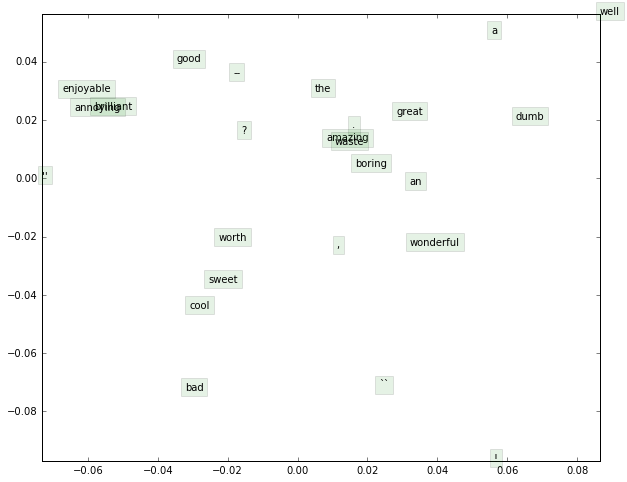

In [16]:
# Visualize the word vectors you trained

tokens = corpus.tokens()
wordVectors = (w2vecNet.W_in_values + w2vecNet.W_out_values)
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", "good", "great", "cool", "brilliant", "wonderful", "well", "amazing", "worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", "annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))